In [ ]:
!gdown 1TC5lvMLoXMc4waX-BQCoUFe8l8JMdcev

In [ ]:
!unzip boards2.zip

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage
import yaml

In [4]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def load_board_extractor_state(path):
    with open(path) as f:
        board_annotation = yaml.load(f, Loader=yaml.FullLoader)

    return board_annotation

## Board recognition

In [ ]:
!pip install ultralytics

In [6]:
import tqdm
import os
from PIL import Image
import collections
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from ultralytics import YOLO


ROOT = 'dataset'

def read_annot(path):
    with open(path) as f:
        annot = f.read()
    return annot

def get_dataset(path):
    dataset = []
    for dirname, _, filenames in tqdm.tqdm(os.walk(path)):
        for filename in filenames:
            if filename.endswith('.jpg') or filename.endswith('.JPG') or filename.endswith('.png'):
                row = {}
                image = cv2.imread(os.path.join(dirname, filename))
                row['image'] = image
                row['path'] = os.path.join(dirname, filename)

                if os.path.exists(os.path.join(dirname, filename[:-4] + '.txt')):
                    row['annot'] = read_annot(os.path.join(dirname, filename[:-4] + '.txt'))

                if os.path.exists(os.path.join(dirname, filename[:-4] + '.TXT')):
                    row['annot'] = read_annot(os.path.join(dirname, filename[:-4] + '.TXT'))

                if os.path.exists(os.path.join(dirname, 'board_extractor_state.yml')):
                    row['pts_clicks'] = load_board_extractor_state(os.path.join(dirname, 'board_extractor_state.yml'))['pts_clicks']

                dataset.append(row)
    return dataset

In [7]:
dataset = get_dataset(ROOT)

41it [01:33,  2.27s/it]


In [8]:
class GoDataset(Dataset):
  def __init__(self, dataset):
    self.data = dataset

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if 'pts_clicks' in self.data[idx]:
      return np.array(self.data[idx]['image']), np.array(self.data[idx]['pts_clicks'])
    else:
      return np.array(self.data[idx]['image']), np.zeros((4, 2))

In [9]:
go_dataset = GoDataset(dataset)
train_size = int(0.8 * len(go_dataset))
val_size = len(go_dataset) - train_size
train_go, val_go = torch.utils.data.random_split(go_dataset, [train_size, val_size])

In [10]:
!mkdir datasets
!mkdir datasets/data
!mkdir datasets/data/train
!mkdir datasets/data/val

In [11]:
for i in range(len(train_go)):
  img, corners = train_go[i]

  if np.all(corners == 0):
    continue

  im = Image.fromarray(img)
  im.save(f"datasets/data/train/image{i}.jpg")

  y, x = img.shape[:2]

  np.savetxt(f"datasets/data/train/image{i}.txt", np.hstack([np.arange(4).reshape(4, 1),
                                                  corners / np.array([x, y]),
                                                  np.ones((4, 2)) * 0.05]))

In [12]:
for i in range(len(val_go)):
  img, corners = val_go[i]

  if np.all(corners == 0):
    continue

  im = Image.fromarray(img)
  im.save(f"datasets/data/val/image{i}.jpg")

  y, x = img.shape[:2]

  corners / np.array([x, y])

  np.savetxt(f"datasets/data/val/image{i}.txt", np.hstack([np.arange(4).reshape(4, 1),
                                                  corners / np.array([x, y]),
                                                  np.ones((4, 2)) * 0.05]))

In [13]:
# Writing the specified data.yaml file using Python

yaml_path = 'data.yaml'  # Define the file path (adjust as needed)

with open(yaml_path, 'w') as file:
    file.write(
        "# data.yaml\n"
        "train: data/train  # path to the folder containing training images and labels\n"
        "val: data/val \n"
        "nc: 4 \n"
        "names: ['top-left', 'top-right', 'bottom-right', 'bottom-left']\n"
    )

print(f"Created 'data.yaml' at: {yaml_path}")

Created 'data.yaml' at: data.yaml


In [14]:
model = YOLO('yolov8n.pt')

results = model.train(
  data='data.yaml',
  imgsz=640,
  epochs=1,
  batch=2,
  name='yolov8n_corners')

100%|██████████| 6.23M/6.23M [00:00<00:00, 104MB/s]


Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=1, time=None, patience=50, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_corners, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torc

100%|██████████| 755k/755k [00:00<00:00, 19.3MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/data/train... 829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 829/829 [00:00<00:00, 1970.23it/s]

train: New cache created: /content/datasets/data/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/data/val... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<00:00, 1377.03it/s]

val: New cache created: /content/datasets/data/val.cache


Plotting labels to runs/detect/yolov8n_corners/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1     0.625G      2.516      3.243      1.314          8        640: 100%|██████████| 415/415 [01:04<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:11<00:00,  4.37it/s]


                   all        206        824      0.714      0.771      0.867      0.453

1 epochs completed in 0.023 hours.
Optimizer stripped from runs/detect/yolov8n_corners/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_corners/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_corners/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:07<00:00,  6.81it/s]


                   all        206        824      0.714      0.771      0.866      0.454
              top-left        206        206      0.766      0.981       0.97      0.529
             top-right        206        206      0.591      0.855      0.815      0.398
          bottom-right        206        206      0.806      0.343      0.765      0.442
           bottom-left        206        206      0.695      0.903      0.914      0.445
Speed: 0.3ms preprocess, 7.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/yolov8n_corners


In [9]:
results = model.predict(source='dataset/2/67.png', line_thickness=1, conf=0.25, save_txt=True, save=True)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

image 1/1 /content/dataset/2/67.png: 640x640 2 bottom-rights, 15.6ms
Speed: 5.2ms preprocess, 15.6ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolov8n_corners42
1 label saved to runs/detect/yolov8n_corners42/labels


In [15]:
def detect_corners_yolo(image, model):
    # YOLO model trained to detect corners on a chessboard
    model_trained = model.cpu()
    results = model_trained.predict(source=image, line_thickness=1, conf=0.25, save_txt=True, save=True)

    # get the corners coordinates from the model
    boxes = results[0].boxes
    arr = boxes.xywh.numpy()
    points = arr[:,0:2]

    if len(points) != 0:
      corners = order_points(points)
    else:
      corners = points

    image_arr = cv2.imread(image)

    return corners, image_arr

In [16]:
corners, image = detect_corners_yolo('datasets/data/val/image3.jpg', model)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

image 1/1 /content/datasets/data/val/image3.jpg: 480x640 1 top-left, 2 top-rights, 1 bottom-right, 1 bottom-left, 188.3ms
Speed: 7.6ms preprocess, 188.3ms inference, 38.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/yolov8n_corners2
1 label saved to runs/detect/yolov8n_corners2/labels


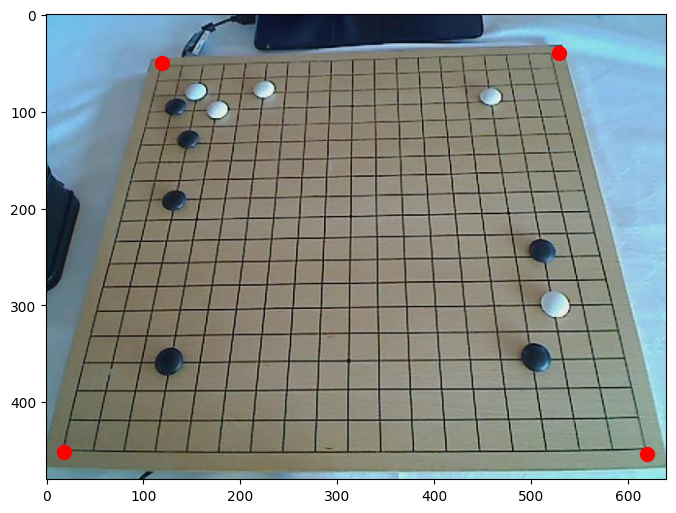

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.scatter([pt[0] for pt in corners], [pt[1] for pt in corners], c='red', s=100)
plt.show()

In [ ]:
dists = []

for i in range(len(val_go)):
  if i == 68 or i == 135:
    continue
  img, corners = val_go[i]
  image_name = f'image{i}.jpg'
  corners_preds, _ = detect_corners_yolo('datasets/data/val/' + image_name, model)

  if len(corners_preds) != 0:
    dists.append(np.sqrt(((corners - corners_preds)**2).sum(axis=1)))

In [34]:
dists = np.stack(dists)

In [45]:
(dists < 10).mean()

0.7694174757281553

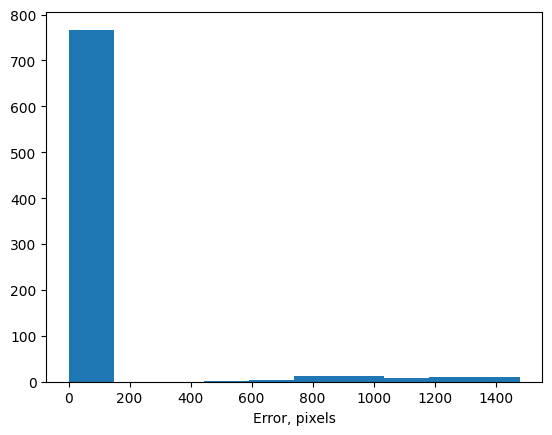

In [50]:
plt.hist(dists.flatten())
plt.xlabel('Error, pixels')
plt.show()

In [39]:
(dists < 10).prod(axis=1).mean()

0.5825242718446602

In [31]:
np.stack(dists).mean()

79.48706807898998